# Image Reconstruction using Linear Regression

This notebook demonstrates the use of Random Fourier Features (RFF) to transform image coordinates and train a linear regression model for image reconstruction.

#### 1. Image Loading and Preprocessing:
- The image is loaded with `torchvision.io.read_image`, reshaped, normalized using `MinMaxScaler` and cropped.

#### 2. Coordinate Map Creation:
- The `create_coordinate_map` function generates a 2D grid of pixel coordinates, reshaping the image into a format where each pixel is paired with its corresponding (x, y) coordinates.

#### 3. Scaling and Transforming Coordinates:
- Pixel coordinates are scaled to the range [-1, 1] using `MinMaxScaler`.
- RFF are generated from the scaled coordinates using `RBFSampler` (Scikit-learn) to create a higher-dimensional feature space.

#### 6. Random Fourier Features (RFF) Creation:
- RFF are used to approximate the Radial Basis Function (RBF) kernel, allowing us to map input data into a higher-dimensional space. This mapping helps in capturing complex patterns in the image's spatial coordinates.
- The `create_rff_features` function applies the `RBFSampler` from Scikit-learn to the scaled image coordinates, generating a set of random features based on the RBF kernel. These features are then used as input to the linear regression model, providing a more expressive representation of the image structure for the reconstruction task.

#### 4. Linear Model Training:
- A simple linear regression model (`LinearModel`) is defined using `torch.nn.Linear`.
- The model is trained with Adam optimizer and MSE loss to predict pixel values from the transformed RFF features.

#### 5. Image Reconstruction and Evaluation:
- The trained model reconstructs the image.
- Original and reconstructed images are compared visually using `matplotlib`.
- Metrics such as RMSE (Root Mean Square Error) and PSNR (Peak Signal-to-Noise Ratio) are computed to evaluate performance.


In [29]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

### Image Loading and Visualization

We load the image using `torchvision.io.read_image`, which reads it as a tensor in the format `(C, H, W)`. To display the image using `matplotlib`, we rearrange it to `(H, W, C)` using `einops.rearrange`, since `plt.imshow` expects the channel dimension last. This lets us inspect the original image before further processing.


torch.Size([3, 1599, 899])


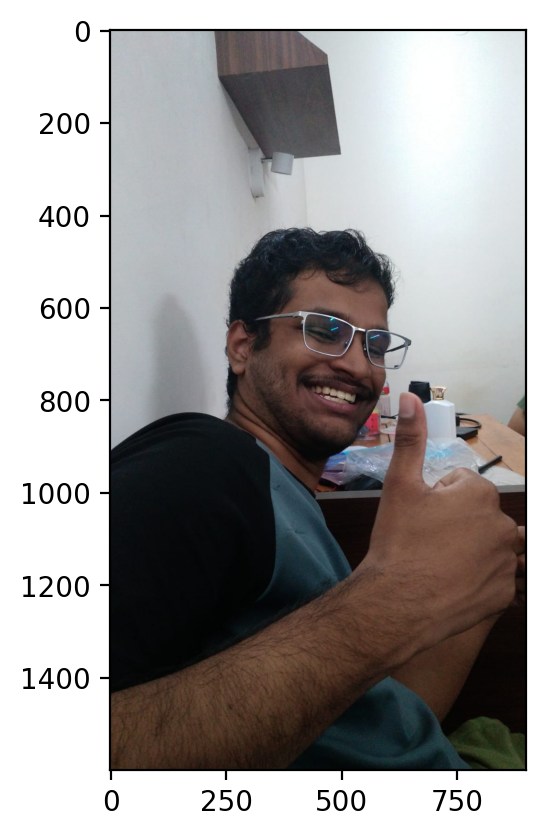

In [30]:
img = torchvision.io.read_image("sample-images/bro.jpg")
print(img.shape)
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

# Image Preprocessing

In [31]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [32]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
print(img_scaled.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled

(3, 1599, 899)


tensor([[[0.7098, 0.7333, 0.7490,  ..., 0.8667, 0.8784, 0.8824],
         [0.7216, 0.7333, 0.7333,  ..., 0.8667, 0.8784, 0.8824],
         [0.7333, 0.7255, 0.7098,  ..., 0.8627, 0.8706, 0.8745],
         ...,
         [0.2706, 0.2745, 0.2745,  ..., 0.2745, 0.2745, 0.2627],
         [0.2706, 0.2784, 0.2824,  ..., 0.2588, 0.2549, 0.2510],
         [0.2706, 0.2824, 0.2902,  ..., 0.2627, 0.2510, 0.2510]],

        [[0.7255, 0.7490, 0.7725,  ..., 0.8824, 0.8824, 0.8863],
         [0.7373, 0.7490, 0.7569,  ..., 0.8824, 0.8824, 0.8863],
         [0.7490, 0.7412, 0.7333,  ..., 0.8824, 0.8863, 0.8902],
         ...,
         [0.1804, 0.1843, 0.1843,  ..., 0.3176, 0.3137, 0.3059],
         [0.1804, 0.1882, 0.1922,  ..., 0.2941, 0.2941, 0.2902],
         [0.1804, 0.1922, 0.2000,  ..., 0.2902, 0.2902, 0.2902]],

        [[0.7294, 0.7529, 0.7725,  ..., 0.8941, 0.8980, 0.9020],
         [0.7412, 0.7529, 0.7569,  ..., 0.8941, 0.8980, 0.9020],
         [0.7529, 0.7451, 0.7333,  ..., 0.8941, 0.8980, 0.

### Cropping the image
- We crop the image to focus on a 300x300 section of the subject's face

In [33]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 550, 300, 300, 300)
crop.shape

torch.Size([3, 300, 300])

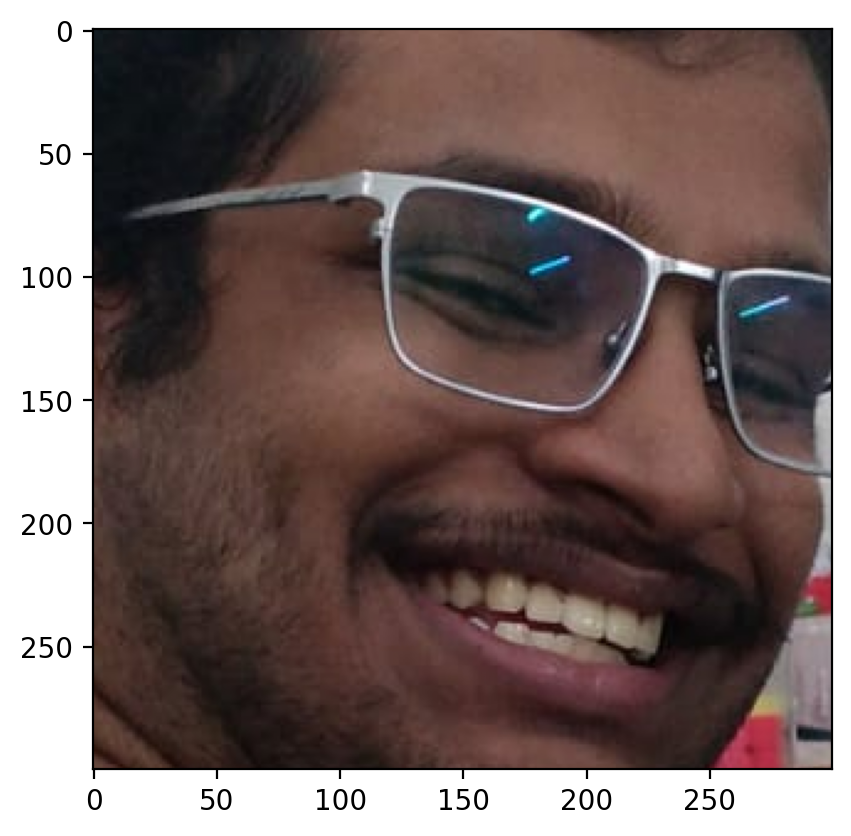

In [34]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [35]:
crop = crop.to(device)
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 300 300


### The `create_coordinate_map` Function

This function generates a 2D grid of pixel coordinates and reshapes the image for use in machine learning models.

#### Steps:
1. **Input**: Takes an image tensor of shape `(num_channels, height, width)`.
2. **2D Coordinates (`X`)**: Creates a tensor of pixel coordinates `(x, y)` for each pixel in the image, with shape `(height * width, 2)`.
3. **Image Reshaping (`Y`)**: Reshapes the image into a tensor of pixel values `(height * width, num_channels)`.
4. **Output**: Returns `X` (coordinates) and `Y` (corresponding pixel values), allowing each pixel to be represented by its position and value for tasks like image reconstruction.


In [36]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

bro_X, bro_Y = create_coordinate_map(crop)

bro_X.shape, bro_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [37]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(bro_X.cpu())

# Scale the X coordinates
bro_X_scaled = scaler_X.transform(bro_X.cpu())

# Move the scaled X coordinates to the GPU
bro_X_scaled = torch.tensor(bro_X_scaled).to(device)

# Set to dtype float32
bro_X_scaled = bro_X_scaled.float()

### Utility Functions

In [55]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)
    
    
    # create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

def plot_reconstructed_and_original_image(original_img, reconstructed_image, title=""):
    """
    original_img: torch.Tensor of shape (num_channels, height, width)
    reconstructed_image: torch.Tensor of shape (height, width, num_channels)
    """
    # Plotting the original and reconstructed images side by side
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    # Plot the reconstructed image
    ax0 = plt.subplot(gs[0])
    ax0.imshow(reconstructed_image)
    ax0.set_title("Reconstructed Image")
    ax0.axis("off")

    # Plot the original image
    ax1 = plt.subplot(gs[1])
    ax1.imshow(original_img.cpu().permute(1, 2, 0))  # Permute to (H, W, C) for plotting
    ax1.set_title("Original Image")
    ax1.axis("off")

    # Add title and layout adjustments
    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    plt.show()


def generate_reconstructed_image(net, X, height, width, num_channels, device = torch.device("cuda")):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    
    return: torch.Tensor of shape (height, width, num_channels) (the reconstructed image)
    device: str, either 'cpu' or 'cuda'
    """
    # Ensure the model and input are on the same device
    net = net.to(device)
    X = X.to(device)

    net.eval()
    with torch.no_grad():
        outputs = net(X)  # Generate reconstructed image
        outputs = outputs.reshape(height, width, num_channels)  # Reshape to image dimensions
    
    return outputs.cpu()  # Return reconstructed image on CPU for plotting

def print_reconstruction_metrics(original_img, reconstructed_img, title="Reconstruction Metrics"):
    """
    Prints the RMSE and PSNR between the original and reconstructed images.

    original_img: torch.Tensor of shape (num_channels, height, width)
    reconstructed_img: torch.Tensor of shape (num_channels, height, width)
    """
    original_img = original_img.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
    reconstructed_img = reconstructed_img.cpu().numpy()

    def calculate_rmse(original, compressed):
        mse = np.mean((original - compressed) ** 2)
        rmse = np.sqrt(mse)
        return rmse

    def calculate_psnr(original, compressed):
        mse = np.mean((original - compressed) ** 2)
        if mse == 0:
            return float('inf')
        max_pixel = np.max(original)
        psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
        return psnr
    # Calculate RMSE and PSNR
    rmse = calculate_rmse(original_img, reconstructed_img)
    psnr = calculate_psnr(original_img, reconstructed_img)

    # Print results
    print(f"{title}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"PSNR: {psnr:.2f} dB")


### Random Fourier Features (RFF)

To approximate the Radial Basis Function (RBF) kernel, Random Fourier Features (RFF) project input data into a higher-dimensional space. The RBF kernel between two points $ \mathbf{x} $ and $ \mathbf{y} $ is defined as:

$$
k(\mathbf{x}, \mathbf{y}) = \exp\left( -\frac{\|\mathbf{x} - \mathbf{y}\|^2}{2\sigma^2} \right)
$$

To approximate this kernel, we use the following transformation:

1. Draw random vectors $ \mathbf{w}_i \in \mathbb{R}^d $ from a normal distribution $ \mathcal{N}(0, \frac{1}{\sigma^2}) $, where $ \sigma $ is the kernel width.
2. Compute the RFF features $ \mathbf{z}(\mathbf{x}) $ for an input $ \mathbf{x} $ as:

$$
\mathbf{z}(\mathbf{x}) = \sqrt{\frac{2}{D}} \left[ \cos(\mathbf{w}_1^\top \mathbf{x} + b_1), \dots, \cos(\mathbf{w}_D^\top \mathbf{x} + b_D) \right]
$$

where $ D $ is the number of random features, and $ b_i $ are drawn uniformly from $ [0, 2\pi] $.

These features $ \mathbf{z}(\mathbf{x}) $ are used as input to the linear model to approximate the RBF kernel in a computationally efficient manner.


### Generate Random Fourier Features (RFF) from the scaled coordinates
- The number of features is set to 37,500, and the sigma (kernel width) is set to 0.008. These parameters were used from the [Instructor's notebook](https://github.com/nipunbatra/ml-teaching/blob/master/notebooks/siren.ipynb) for Image Reconstruction using RFF.


In [12]:
X_rff = create_rff_features(bro_X_scaled, 37500, 0.008)

print(X_rff.shape)

# Initialize the LinearModel with input size equal to the number of RFF features
# The output size is 3, corresponding to the RGB channels of the image
net = LinearModel(X_rff.shape[1], 3)

# Move the model to the appropriate device (GPU or CPU)
net.to(device)

torch.Size([90000, 37500])


LinearModel(
  (linear): Linear(in_features=37500, out_features=3, bias=True)
)

### Training the Linear Regression Model

In [13]:
train(net, 0.005, X_rff, bro_Y, 2500)

Epoch 0 loss: 0.091137
Epoch 100 loss: 0.004802
Epoch 200 loss: 0.001952
Epoch 300 loss: 0.000913
Epoch 400 loss: 0.000502
Epoch 500 loss: 0.000339
Epoch 600 loss: 0.000275
Epoch 700 loss: 0.000249
Epoch 800 loss: 0.000239
Epoch 900 loss: 0.000235
Epoch 1000 loss: 0.000232
Epoch 1100 loss: 0.000231
Epoch 1200 loss: 0.000229
Epoch 1300 loss: 0.000228
Epoch 1400 loss: 0.000228
Epoch 1500 loss: 0.000227
Epoch 1600 loss: 0.000226
Epoch 1700 loss: 0.000226
Epoch 1800 loss: 0.000225
Epoch 1900 loss: 0.000225
Epoch 2000 loss: 0.000224
Epoch 2100 loss: 0.000224
Epoch 2200 loss: 0.000224
Epoch 2300 loss: 0.000223
Epoch 2400 loss: 0.000223


0.00022275887022260576

In [39]:
# Assuming crop is your original image
num_channels, height, width = crop.shape
print(crop.shape)

torch.Size([3, 300, 300])


### Reconstructed Image

torch.Size([300, 300, 3])


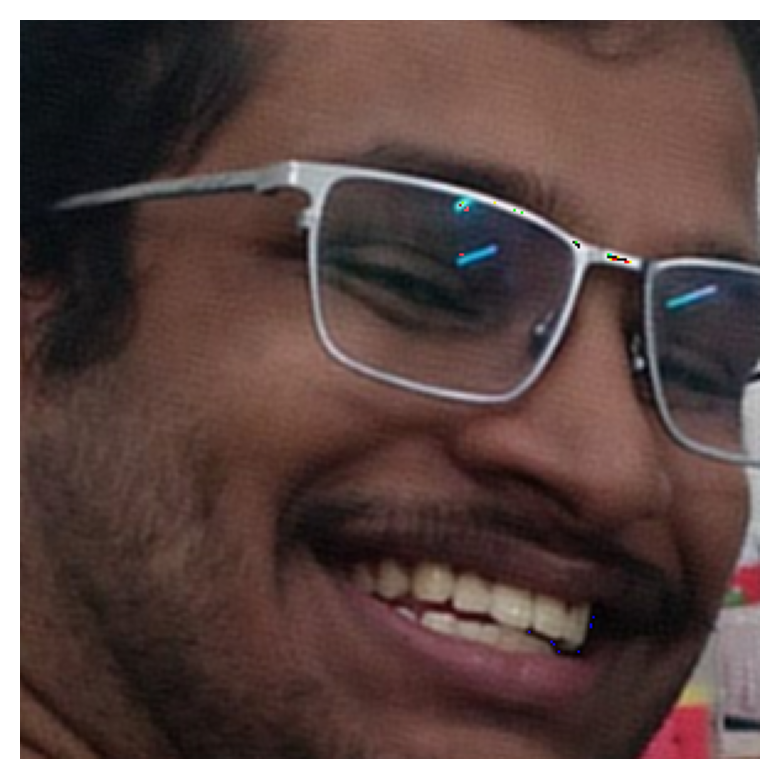

In [40]:
import matplotlib.pyplot as plt
from PIL import Image

# Generate reconstructed image from the model and X coordinates
reconstructed_image = generate_reconstructed_image(net, X_rff, height, width, num_channels)
print(reconstructed_image.shape)
# Convert the reconstructed tensor to numpy array and scale it back to [0, 255]
reconstructed_image_np = (reconstructed_image.cpu().numpy() * 255).astype(np.uint8)

# Display the image using matplotlib
plt.imshow(reconstructed_image_np)
plt.axis('off')  # Hide axes
plt.show()

# Save using PIL
reconstructed_img_pil = Image.fromarray(reconstructed_image_np)
# Save the image
reconstructed_img_pil.save('sample_images/reconstructed_bro.png')


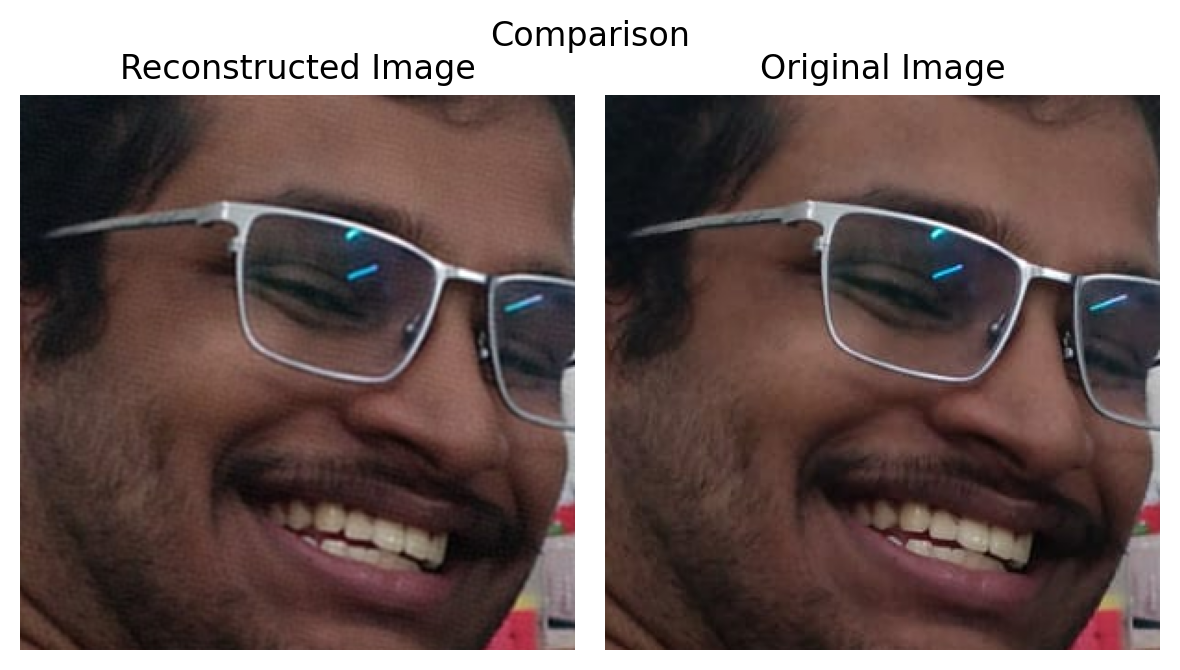

In [45]:
# Plot both the original and reconstructed images
plot_reconstructed_and_original_image(crop, reconstructed_image, title="Comparison")

## Image Reconstruction Metrics

To evaluate the quality of image reconstruction, we use two key metrics: **Root Mean Square Error (RMSE)** and **Peak Signal-to-Noise Ratio (PSNR)**. 

#### 1. **Root Mean Square Error (RMSE)**:
RMSE measures the average difference between the pixel values of the original image and the reconstructed image. It is defined as:

$$
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (I_{\text{original},i} - I_{\text{reconstructed},i})^2}
$$

Where:
- $ N $ is the total number of pixels.
- $ I_{\text{original},i} $ is the pixel value in the original image.
- $ I_{\text{reconstructed},i} $ is the pixel value in the reconstructed image.

A lower RMSE indicates that the reconstructed image is closer to the original.

#### 2. **Peak Signal-to-Noise Ratio (PSNR)**:
PSNR measures the ratio between the maximum possible pixel value and the error (RMSE) between the original and reconstructed images. It is expressed in decibels (dB):

$$
\text{PSNR} = 20 \log_{10} \left( \frac{I_{\text{max}}}{\text{RMSE}} \right)
$$

Where $ I_{\text{max}} $ is the maximum possible pixel value (e.g., 255 for an 8-bit image).

A higher PSNR value indicates better image reconstruction quality. Typically, PSNR values above 30 dB are considered good for most image reconstruction tasks.

#### Importance in Linear Regression on RFF:
- **RMSE** shows how well the linear regression model using RFF is able to minimize pixel-wise errors.
- **PSNR** provides a scale-invariant measure of the reconstruction quality, helping to assess whether the reconstructed image maintains visual fidelity.



In [56]:
print_reconstruction_metrics(crop, reconstructed_image, title="Reconstruction Metrics")

Reconstruction Metrics:
RMSE: 0.0149
PSNR: 36.52 dB
